In [1]:
import numpy as np
import imageio as misc
import numpy as np
import matplotlib.pyplot as plt

"""
   Convert an RGB image to grayscale.

   This function applies a fixed weighting of the color channels to form the
   resulting intensity image.

   Arguments:
      rgb   - a 3D numpy array of shape (sx, sy, 3) storing an RGB image

   Returns:
      gray  - a 2D numpy array of shape (sx, sy) storing the corresponding
              grayscale image
"""
def rgb2gray(rgb):
    gray = np.dot(rgb[...,:3],[0.29894, 0.58704, 0.11402])
    return gray
def load_image(filename):
    image = misc.imread(filename)
    if (image.ndim == 3):
        image = rgb2gray(image)
    return image


## fname = '/home/nian/Desktop/hw1_release/data/69015.jpg'
fname = 'C:/Users/59381/Desktop/hw2_release/data/shanghai/shanghai-17.png'
image = load_image(fname)
plt.imshow(image, cmap = 'gray',vmin=0, vmax=255)
plt.show()


<Figure size 640x480 with 1 Axes>

"""
   INTEREST POINT OPERATOR (12 Points Implementation + 3 Points Write-up)

   Implement an interest point operator of your choice.

   Your operator could be:

   (A) The Harris corner detector (Szeliski 4.1.1)

               OR

   (B) The Difference-of-Gaussians (DoG) operator defined in:
       Lowe, "Distinctive Image Features from Scale-Invariant Keypoints", 2004.
       https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf

               OR

   (C) Any of the alternative interest point operators appearing in
       publications referenced in Szeliski or in lecture

              OR

   (D) A custom operator of your own design

   You implementation should return locations of the interest points in the
   form of (x,y) pixel coordinates, as well as a real-valued score for each
   interest point.  Greater scores indicate a stronger detector response.

   In addition, be sure to apply some form of spatial non-maximum suppression
   prior to returning interest points.

   Whichever of these options you choose, there is flexibility in the exact
   implementation, notably in regard to:

   (1) Scale

       At what scale (e.g. over what size of local patch) do you operate?

       You may optionally vary this according to an input scale argument.

       We will test your implementation at the default scale = 1.0, so you
       should make a reasonable choice for how to translate scale value 1.0
       into a size measured in pixels.

   (2) Nonmaximum suppression

       What strategy do you use for nonmaximum suppression?

       A simple (and sufficient) choice is to apply nonmaximum suppression
       over a local region.  In this case, over how large of a local region do
       you suppress?  How does that tie into the scale of your operator?

   For making these, and any other design choices, keep in mind a target of
   obtaining a few hundred interest points on the examples included with
   this assignment, with enough repeatability to have a large number of
   reliable matches between different views.

   If you detect more interest points than the requested maximum (given by
   the max_points argument), return only the max_points highest scoring ones.

   In addition to your implementation, include a brief write-up (in hw2.pdf)
   of your design choices.

   Arguments:
      image       - a grayscale image in the form of a 2D numpy array
      max_points  - maximum number of interest points to return
      scale       - (optional, for your use only) scale factor at which to
                    detect interest points

   Returns:
      xs          - numpy array of shape (N,) containing x-coordinates of the
                    N detected interest points (N <= max_points)
      ys          - numpy array of shape (N,) containing y-coordinates
      scores      - numpy array of shape (N,) containing a real-valued
                    measurement of the relative strength of each interest point
                    (e.g. corner detector criterion OR DoG operator magnitude)

In [6]:
from util import *
from visualize import *
from hw2 import *
from canny import *

In [5]:
def find_interest_points(image, max_points = 200, scale = 1.0):
   # check that image is grayscale
    assert image.ndim == 2, 'image should be grayscale'
   ##########################################################################
   # TODO: YOUR CODE HERE
    mag, theta = canny_nmax(image)
##    image = nonmax_suppress(mag,theta)
    m = len(image)
    n = len(image[0])
    xs= np.zeros(m*n)
    ys = np.zeros(m*n)
    scores= np.zeros(m*n)
    sobel = sobel_gradients(image)
    I_x = sobel[0]
    I_y = sobel[1]
    ## apply window function, gaussian
    Ixx = conv_2d_gaussian(I_x**2,scale)
    Ixy = conv_2d_gaussian(I_y*I_x,scale)
    Iyy = conv_2d_gaussian(I_y**2,scale)
    
    # determinant
    det = Ixx * Iyy - Ixy ** 2
    # trace
    trace = Ixx + Iyy
    R= det - 0.06 * trace ** 2
    
    R = nonmax_suppress(R,theta)
    counter = 0
    for row,row_val in enumerate(R):
        for col, r in enumerate(row_val):
            if r > 0:
                xs[counter] = row
                ys[counter] = col
                scores[counter] = r
                counter += 1
    if len(scores) > max_points:
        copy = scores.copy()
        copy.sort()
        bar = copy[::-1][max_points]
        
        xs = xs[scores > bar]
        ys = ys[scores > bar]
        scores = scores[scores>bar]
                
    
   ##raise NotImplementedError('find_interest_points')
   ##########################################################################
    return np.array(xs), np.array(ys), np.array(scores)

In [7]:
res = find_interest_points(image, max_points = 200, scale = 1.0)
res[0].shape


(200,)

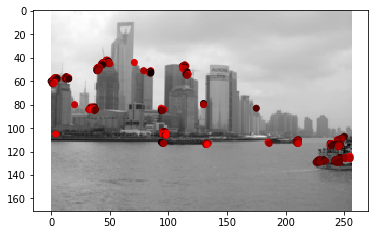

In [8]:
N = 200
xs0, ys0, scores0 = find_interest_points(image, N, 1.0)

plot_interest_points(image, xs0, ys0, scores0)
plt.show(block = False)

   FEATURE DESCRIPTOR (12 Points Implementation + 3 Points Write-up)

   Implement a SIFT-like feature descriptor by binning orientation energy
   in spatial cells surrounding an interest point.

   Unlike SIFT, you do not need to build-in rotation or scale invariance.

   A reasonable default design is to consider a 3 x 3 spatial grid consisting
   of cell of a set width (see below) surrounding an interest point, marked
   by () in the diagram below.  Using 8 orientation bins, spaced evenly in
   [-pi,pi), yields a feature vector with 3 * 3 * 8 = 72 dimensions.

             ____ ____ ____
            |    |    |    |
            |    |    |    |
            |____|____|____|
            |    |    |    |
            |    | () |    |
            |____|____|____|
            |    |    |    |
            |    |    |    |
            |____|____|____|

                 |----|
                  width

   You will need to decide on a default spatial width.  Optionally, this can
   be a multiple of a scale factor, passed as an argument.  We will only test
   your code by calling it with scale = 1.0.

   In addition to your implementation, include a brief write-up (in hw2.pdf)
   of your design choices.

  Arguments:
      image    - a grayscale image in the form of a 2D numpy
      xs       - numpy array of shape (N,) containing x-coordinates
      ys       - numpy array of shape (N,) containing y-coordinates
      scale    - scale factor

   Returns:
      feats    - a numpy array of shape (N,K), containing K-dimensional
                 feature descriptors at each of the N input locations
                 (using the default scheme suggested above, K = 72)

This histogram would peak at some point. The bin at which we see the peak will be the orientation for the keypoint. Additionally, if there is another significant peak (seen between 80 – 100%), then another keypoint is generated with the magnitude and scale the same as the keypoint used to generate the histogram. And the angle or orientation will be equal to the new bin that has the peak.

Effectively at this point, we can say that there can be a small increase in the number of keypoints.



This is the final step for SIFT. So far, we have stable keypoints that are scale-invariant and rotation invariant. In this section, we will use the neighboring pixels, their orientations, and magnitude, to generate a unique fingerprint for this keypoint called a ‘descriptor’.

Additionally, since we use the surrounding pixels, the descriptors will be partially invariant to illumination or brightness of the images.

We will first take a 16×16 neighborhood around the keypoint. This 16×16 block is further divided into 4×4 sub-blocks and for each of these sub-blocks, we generate the histogram using magnitude and orientation.

In [9]:
xs,ys,score = find_interest_points(image, max_points = 200, scale = 1.0)


def extract_features(image, xs, ys, scale = 1.0):
   # check that image is grayscale
    assert image.ndim == 2, 'image should be grayscale'
   ##########################################################################
   # TODO: YOUR CODE HERE
   ##raise NotImplementedError('extract_features')
   ##########################################################################
    bin_width = 360/8
    mag, theta = canny_nmax(image)
    set_width = int(scale*2 + 1)
    length = len(xs)
    feats = []
    for i in range(length):
        x_temp = xs[i]
        y_temp = ys[i]
        temp_array = []
        ## begin 9*9
        left = int(x_temp -(set_width-1)/2-set_width)
        right = int(x_temp +(set_width-1)/2+set_width)
        
        top = int(y_temp-(set_width-1)/2-set_width)
        down = int(y_temp +(set_width-1)/2+set_width)
        ## check boundary
        if left < 0 or top < 0:
            continue
        if right >len(image[0]) or down > len(image):
            continue
            
        for wind_x in range(left,right,set_width):
            for wind_y in range(top,down,set_width):
                hist = np.zeros(8)
            ## begin 3*3
                for m in range(wind_x,wind_x+set_width):
                    for n in range(wind_y,wind_y+set_width):
                        
                        mag_1 = mag[m][n]
                        theta_1 = theta[m][n]*360/(2*np.pi)
                        bin1 = int(theta_1 // bin_width)
                        hist[bin1] += mag_1
                
                temp_array.append(hist)
        feats.append(np.array(temp_array).flatten())
    
    return np.array(feats)

In [10]:
a =extract_features(image, xs, ys, scale = 1.0)
b = extract_features(image, xs, ys, scale = 1.0)

In [11]:
a.shape

(111, 72)

In [12]:
scores0 = find_interest_points(image, max_points = 200, scale = 1.0)[2]
scores1 = find_interest_points(image, max_points = 200, scale = 1.0)[2]

"""
   FEATURE MATCHING (7 Points Implementation + 3 Points Write-up)

   Given two sets of feature descriptors, extracted from two different images,
   compute the best matching feature in the second set for each feature in the
   first set.

   Matching need not be (and generally will not be) one-to-one or symmetric.
   Calling this function with the order of the feature sets swapped may
   result in different returned correspondences.

   For each match, also return a real-valued score indicating the quality of
   the match.  This score could be based on a distance ratio test, in order
   to quantify distinctiveness of the closest match in relation to the second
   closest match.  It could optionally also incorporate scores of the interest
   points at which the matched features were extracted.  You are free to
   design your own criterion. Note that you are required to implement the naive
   linear NN search. 
   
   
   For 'lsh' and 'kdtree' search mode, you could do either to
   get full credits.

   In addition to your implementation, include a brief write-up (in hw2.pdf)
   of your design choices. 
   You are required to report the efficiency comparison
   between different modes by measure the runtime (check the benchmarking related
   codes in hw2_example.py).

   Arguments:
      feats0   - a numpy array of shape (N0, K), containing N0 K-dimensional
                 feature descriptors (generated via extract_features())
      feats1   - a numpy array of shape (N1, K), containing N1 K-dimensional
                 feature descriptors (generated via extract_features())
      scores0  - a numpy array of shape (N0,) containing the scores for the
                 interest point locations at which feats0 was extracted
                 (generated via find_interest_point())
      scores1  - a numpy array of shape (N1,) containing the scores for the
                 interest point locations at which feats1 was extracted
                 (generated via find_interest_point())
      mode     - 'naive': performs a brute force NN search

               - 'lsh': Implementing the local senstive hashing (LSH) approach
                  for fast feature matching. In LSH, the high dimensional
                  feature vectors are randomly projected into low dimension
                  space which are further binarized as boolean hashcodes. As we
                  group feature vectors by hashcodes, similar vectors may end up
                  with same 'bucket' with high propabiltiy. So that we can
                  accelerate our nearest neighbour matching through hierarchy
                  searching: first search hashcode and then find best
                  matches within the bucket.
                  Advice for impl.:
                  (1) Construct a LSH class with method like
                  compute_hash_code   (handy subroutine to project feature
                                      vector and binarize)
                  generate_hash_table (constructing hash table for all input
                                      features)
                  search_hash_table   (handy subroutine to search hash table)
                  search_feat_nn      (search nearest neighbour for input
                                       feature vector)
                  (2) It's recommended to use dictionary to maintain hashcode
                  and the associated feature vectors.
                  (3) When there is no matching for queried hashcode, find the
                  nearest hashcode as matching. When there are multiple vectors
                  with same hashcode, find the cloest one based on original
                  feature similarity.
                  (4) To improve the robustness, you can construct multiple hash tables
                  with different random project matrices and find the closest one
                  among all matched queries.
                  (5) It's recommended to fix the random seed by random.seed(0)
                  or np.random.seed(0) to make the matching behave consistenly
                  across each running.

               - 'kdtree': construct a kd-tree which will be searched in a more
                  efficient way. https://en.wikipedia.org/wiki/K-d_tree
                  Advice for impl.:
                  (1) The most important concept is to construct a KDNode. kdtree
                  is represented by its root KDNode and every node represents its
                  subtree.
                  (2) Construct a KDNode class with Variables like data (to
                  store feature points), left (reference to left node), right
                  (reference of right node) index (reference of index at original
                  point sets)and Methods like search_knn.
                  In search_knn function, you may specify a distance function,
                  input two points and returning a distance value. Distance
                  values can be any comparable type.
                  (3) You may need a user-level create function which recursively
                  creates a tree from a set of feature points. You may need specify
                  a axis on which the root-node should split to left sub-tree and
                  right sub-tree.


   Returns:
      matches  - a numpy array of shape (N0,) containing, for each feature
                 in feats0, the index of the best matching feature in feats1
      scores   - a numpy array of shape (N0,) containing a real-valued score
                 for each match

In [13]:
def match_features(feats0, feats1, scores0, scores1, mode='naive'):
   ##########################################################################
   # TODO: YOUR CODE HERE
   ## raise NotImplementedError('match_features')
    if mode =='naive':
        ## use NNDR formula on Page 236
        matches = np.zeros(feats0.shape[0],dtype = int)
        scores = np.zeros(feats0.shape[0])
        for i in range(feats0.shape[0]):
            d1 = float('Inf')
            d2 = float('Inf')
            res = -1
            for j in range(feats1.shape[0]):
                d = np.linalg.norm(feats0[i]-feats1[j])
                
                if d < d1:
                    d2 = d1
                    d1 = d
                    res = j
                elif d < d2:
                    d2 = d
            r = d1/d2
            ## each feature of feat0 have a r score
            matches[i] = int(res)
            scores[i] = r
            
   ##########################################################################
    return matches, scores

In [14]:
type(match_features(a, b, scores0, scores1, mode='naive')[0][0])

numpy.int32

In [15]:
import collections
import itertools
import numpy as np
import math

Node = collections.namedtuple("Node", 'data axis index left right')
def square_distance(a, b):
    s = 0
    for x, y in zip(a, b):
        d = x - y
        s += d * d
    return s


class KDTree(object):

    def __init__(self, k, feat):
        def build_tree(feat, axis=0):
            if not feat:
                return None
            feat.sort(key=lambda x: x[0][axis])
            median = len(feat) // 2
            data, index = feat[median]
            next_axis = (axis + 1) % k
            
             
            return Node(data,axis,index,build_tree(feat[:median], next_axis),build_tree(feat[median + 1:], next_axis))

        self.root = build_tree(list(feat))
        
        
    def NN(self, input1):

        best = [None, None, float('inf')]
        # state of search: best point found, its label,
        # lowest squared distance

        def recursive_search(here):

            if here is None:
                return

            data, axis, index, left, right = here

            distance1 = square_distance(data, input1)
            if distance1 < best[2]:
                best[:] = data, index, distance1
                ## if found a closer point, then update to this point and update index

            diff = input1[axis] - data[axis]
            if diff <= 0:
                close, away = (left, right) 
            else:
                close, away = (right, left)
            ## if this point's value on this axis is less than the node, then we will need to search the left subtree
            recursive_search(close)
            
            ## if this point's distance to its previous NN is bigger than this point's distance to boundary,still need to search the right subtree.
            if diff ** 2 < best[2]:
                recursive_search(away)

        recursive_search(self.root)
        return best[0], best[1], math.sqrt(best[2])
    
    
if __name__ == '__main__':   
    k = 5
    points = [(tuple(a[i]), i) for i in range(len(a))]
    tree = KDTree(k, points)
    input1 = [a[i] for i in range(len(a))]
    res = []
    scores = []
    for ele in input1:
        res.append(tree.NN(ele)[1])
        scores.append(tree.NN(ele)[2])
    
    


In [16]:
input1 = [a[i] for i in range(len(a))]
res = []
for ele in input1:
    res.append(tree.NN(ele)[1])
## res will store the NN index

In [17]:
Node = collections.namedtuple("Node", 'data axis index left right')
class KDTree(object):
     ## this code this wiki page as reference : https://en.wikipedia.org/wiki/K-d_tree
    def __init__(self, k, feat):
        def build_tree(feat, axis=0):
            if not feat:
                return None
            feat.sort(key=lambda x: x[0][axis])
            median = len(feat) // 2
            data, index = feat[median]
            next_axis = (axis + 1) % k                        
            return Node(data,axis,index,build_tree(feat[:median], next_axis),build_tree(feat[median + 1:], next_axis))
        self.root = build_tree(list(feat))
               
    def NN(self, input1):
        res = [None, None, float('inf')]
        ## res[2] = distance
        def search_NN(search_value):
            distance1 = 0
            if search_value is None:
                return
            data, axis, index, left, right = search_value
            for i, j in zip(data,input1):
                distance1 += math.sqrt((i-j)*(i-j))
            if distance1 < res[2]:
                res[0] = data
                res[1] = index
                res[2] = distance1
                ## if found a closer point, then update to this point and update index
            diff = input1[axis] - data[axis]
            if diff <= 0:
                close = left
                away = right
            else:
                close = right
                away = left
            ## if this point's value on this axis is less than the node, 
            ## then we will need to search the left subtree, right otherwise
            search_NN(close)
            ## if this point's distance to its previous NN is bigger than this point's distance to boundary,still need to search the right subtree.
        search_NN(self.root)
        return res[0], res[1],res[2]

def match_features(feats0, feats1, scores0, scores1, mode='naive'):
   ##########################################################################
   # TODO: YOUR CODE HERE
   ## raise NotImplementedError('match_features')
    if mode =='naive':
        ## use NNDR formula on Page 236
        matches = np.zeros(feats0.shape[0],dtype= int)
        scores = np.zeros(feats0.shape[0])
        for i in range(feats0.shape[0]):
            d1 = float('Inf')
            d2 = float('Inf')
            res = -1
            for j in range(feats1.shape[0]):
                d = np.linalg.norm(feats0[i]-feats1[j])
                if d < d1:
                    d2 = d1
                    d1 = d
                    res = j
                elif d < d2:
                    d2 = d
            r = d1/d2
            ## each feature of feat0 have a r score
            matches[i] = int(res)
            scores[i] = r
            print(matches)

    if mode == 'kdtree':
        k = 50
        points = [(tuple(feats0[i]), i) for i in range(len(feats0))]
        tree = KDTree(k, points)
          ## put feats 0 into kdtree
        input1 = [feats1[i] for i in range(len(feats1))]
          ## search best matches in feats1 amoung feats0
        matches = []
        scores = []
        for ele in input1:
            matches.append(tree.NN(ele)[1])
            scores.append(1/(tree.NN(ele)[2]))
        matches = np.array(matches)
        scores = np.array(scores)
    
   ##########################################################################
    return matches, scores

In [18]:
def hough_votes(xs0, ys0, xs1, ys1, matches, scores):
   ##########################################################################
   # TODO: YOUR CODE HERE
   ##raise NotImplementedError('hough_votes')
    m = len(xs0)+1
    x_tran = []
    y_tran = []
    for i in range(m):
        x_trans = xs0[i] - xs1[matches[i]]
        y_trans = ys0[i] - ys1[matches[i]]
        x_tran.append(x_trans)
        y_tran.append(y_trans)
        
    x_bin_width = (max(x_tran) - min(x_tran))/100
    ## 100 bins
    y_bin_width = (max(y_tran) - min(y_tran))/100
    
    x_hist = np.zeroes(100)
    y_hist = np.zeros(100)
    for i in range(m):
        x_hist[i] += scores[i]
        y_hist[i] += scores[i]
        
    tx = max(x_hist)
    ty = max(y_hist)
    votes = (x_hist,y_hist)
   ##########################################################################
    return tx, ty, votes